#### Benchmaking Experiment 001
- Model : Model2
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
import math
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import *
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": "glove50-v1",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "dim_feedforward": 128,
    "num_layers": 2,
    "pos_encoding": 'fixed',
    "activation": 'relu',
    "norm": "BatchNorm",
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model7(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, num_layers, dim_feedforward, ft_size, attr_size,
                pos_encoding='fixed', activation='gelu', norm='BatchNorm', max_len=1024, dropout=0.1, freeze=False):
        super(Model7, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.attr_size = attr_size

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)
        # relative global attention layer
        if norm == 'LayerNorm':
            encoder_layer = TransformerEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        else:
            encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)

        self.AttnL = nn.TransformerEncoder(encoder_layer, num_layers)

        # positional encoding concat <-> LSTM 
        self.lstmL = nn.LSTM(input_size=d_model, hidden_size=ft_size, batch_first=True)
        # SAE submodule
        self.EncDenseL = nn.Linear(in_features=ft_size, out_features=attr_size, bias=False)
        self.DecDenseL = nn.Linear(in_features=attr_size, out_features=ft_size, bias=False)
        # override weights
        del self.EncDenseL.weight
        del self.DecDenseL.weight
        # define shared weights
        self.TransMet = nn.Parameter(torch.randn(attr_size, ft_size))

    def forward(self, x):
        x = x.permute(1,0,2)
        out = self.DenseL(x)
        out = self.pos_enc(out)* math.sqrt(self.d_model)
        out = self.AttnL(out)
        out = out.permute(1,0,2)
        lstm_out, hidden = self.lstmL(out)
        # SAE Operation
        self.EncDenseL.weight = self.TransMet
        self.DecDenseL.weight = self.TransMet.T 
        attr_out = self.EncDenseL(lstm_out[:, -1, :])
        ft_out = self.DecDenseL(attr_out)
        return attr_out, ft_out

---

In [4]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [6]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [7]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [8]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


eval: 100%|██████████| 26/26 [00:00<00:00, 50.98batch/s, loss=3.35]


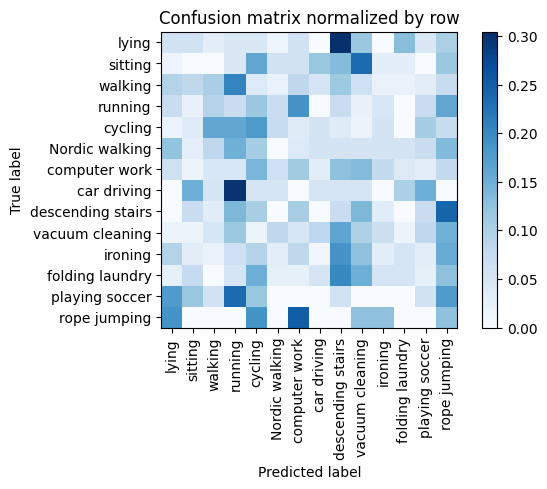

Training Epoch:  10%|█         | 1/10 [00:06<01:01,  6.86s/it]

Overall accuracy: 0.071



eval: 100%|██████████| 26/26 [00:00<00:00, 56.03batch/s, loss=1.63]


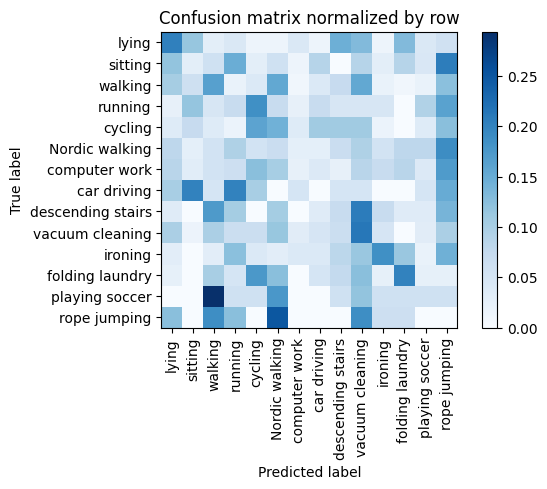

Training Epoch:  20%|██        | 2/10 [00:11<00:46,  5.76s/it]

Overall accuracy: 0.115



eval: 100%|██████████| 26/26 [00:00<00:00, 74.07batch/s, loss=1.12]


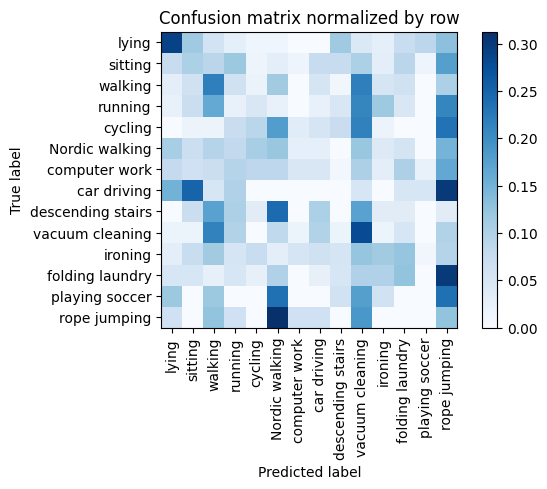

Training Epoch:  30%|███       | 3/10 [00:15<00:33,  4.76s/it]

Overall accuracy: 0.128



eval: 100%|██████████| 26/26 [00:00<00:00, 63.17batch/s, loss=0.9]


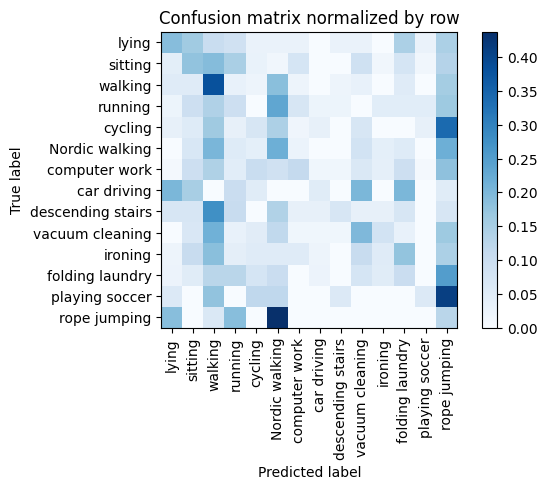

Training Epoch:  40%|████      | 4/10 [00:19<00:25,  4.31s/it]

Overall accuracy: 0.156



eval: 100%|██████████| 26/26 [00:00<00:00, 74.71batch/s, loss=0.652]


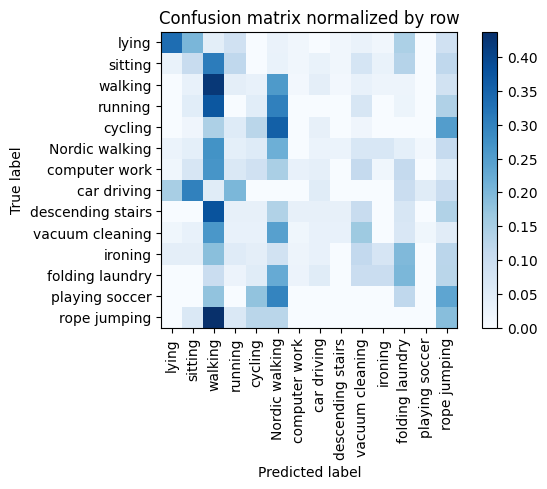

Training Epoch:  50%|█████     | 5/10 [00:22<00:20,  4.06s/it]

Overall accuracy: 0.157



eval: 100%|██████████| 26/26 [00:00<00:00, 47.27batch/s, loss=0.682]


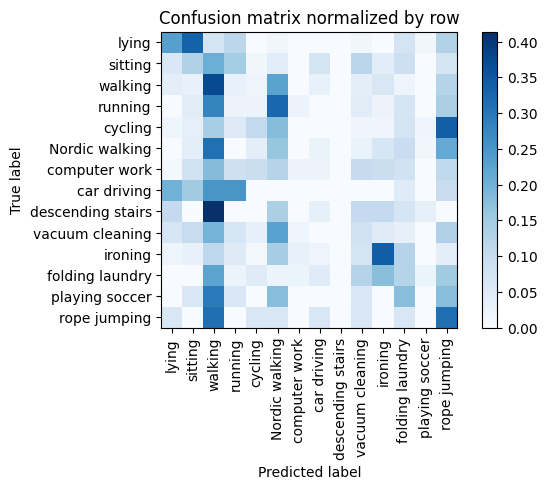

Training Epoch:  60%|██████    | 6/10 [00:27<00:17,  4.47s/it]

Overall accuracy: 0.161



eval: 100%|██████████| 26/26 [00:00<00:00, 42.65batch/s, loss=0.56]


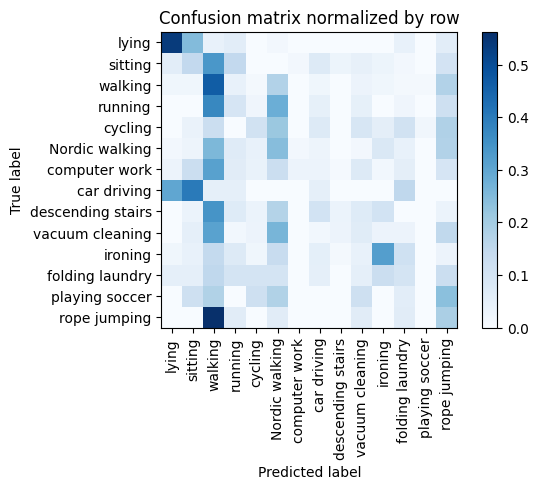

Training Epoch:  70%|███████   | 7/10 [00:34<00:15,  5.19s/it]

Overall accuracy: 0.206



eval: 100%|██████████| 26/26 [00:00<00:00, 45.78batch/s, loss=0.709]


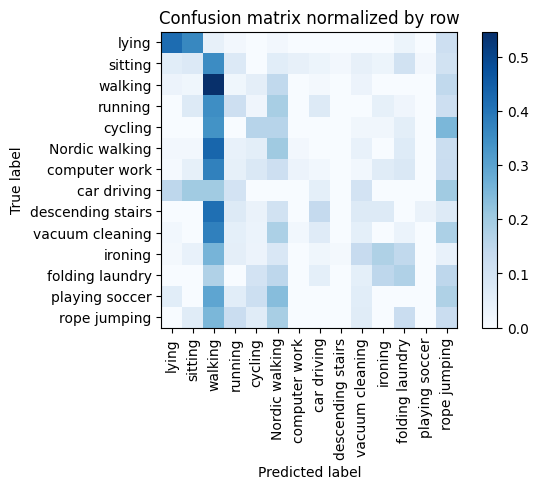

Training Epoch:  80%|████████  | 8/10 [00:40<00:11,  5.56s/it]

Overall accuracy: 0.184



eval: 100%|██████████| 26/26 [00:00<00:00, 50.49batch/s, loss=0.572]


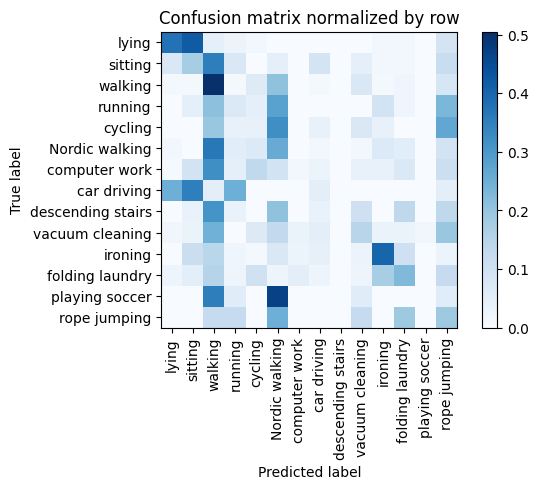

Training Epoch:  90%|█████████ | 9/10 [00:46<00:05,  5.55s/it]

Overall accuracy: 0.213



eval: 100%|██████████| 26/26 [00:00<00:00, 66.33batch/s, loss=0.492]


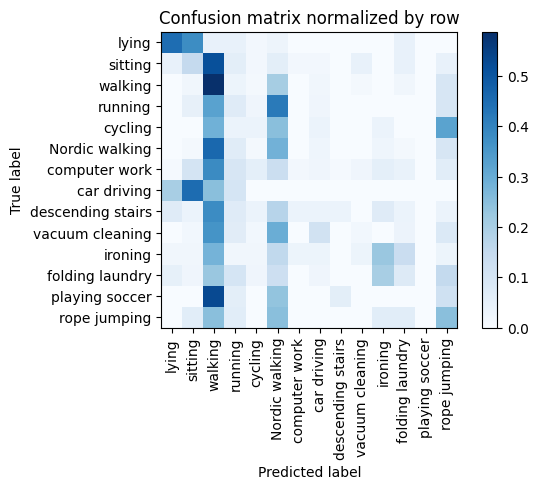

Overall accuracy: 0.193



eval: 100%|██████████| 28/28 [00:00<00:00, 81.03batch/s, loss=0.658]


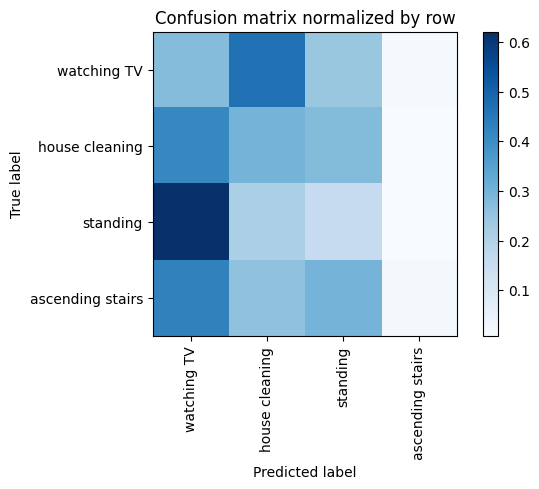

Overall accuracy: 0.194

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.341      0.299      0.319      0.329        288|	 watching TV: 0.417,	standing: 0.278,	
        standing       0.215      0.160      0.183      0.322        282|	 watching TV: 0.621,	house cleaning: 0.213,	
ascending stairs       0.333      0.017      0.033      0.200        175|	 watching TV: 0.429,	standing: 0.297,	house cleaning: 0.257,	
     watching TV       0.089      0.275      0.134      0.150        131|	 house cleaning: 0.466,	standing: 0.244,	

----------------------------------------------------------------------------------------------------
     avg / total       0.261      0.194      0.190        1.0        876|	      

{'total_accuracy': 0.19406392694063926, 'precision': 0.24464603253169498, 'recall': 0.18753439916110454, 'f1': 0.167126203865808}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping',

eval: 100%|██████████| 26/26 [00:00<00:00, 79.03batch/s, loss=5.85]


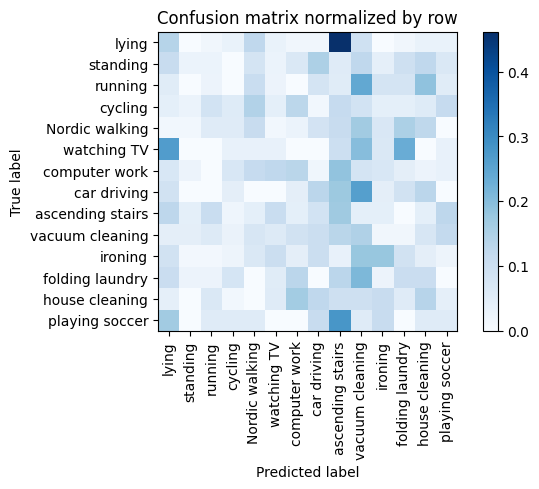

Training Epoch:  10%|█         | 1/10 [00:03<00:33,  3.70s/it]

Overall accuracy: 0.113



eval: 100%|██████████| 26/26 [00:00<00:00, 71.43batch/s, loss=2.39]


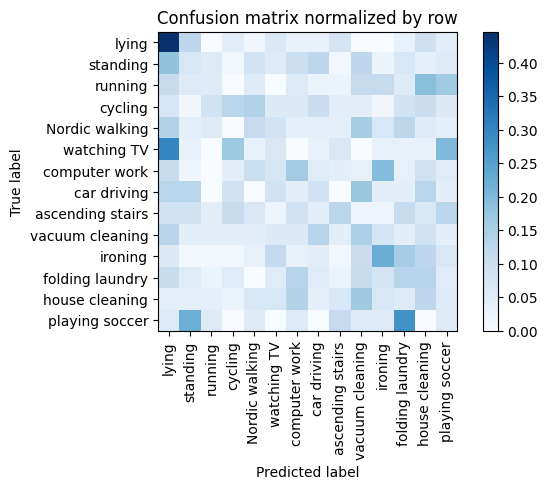

Training Epoch:  20%|██        | 2/10 [00:07<00:29,  3.68s/it]

Overall accuracy: 0.154



eval: 100%|██████████| 26/26 [00:00<00:00, 65.16batch/s, loss=1.4]


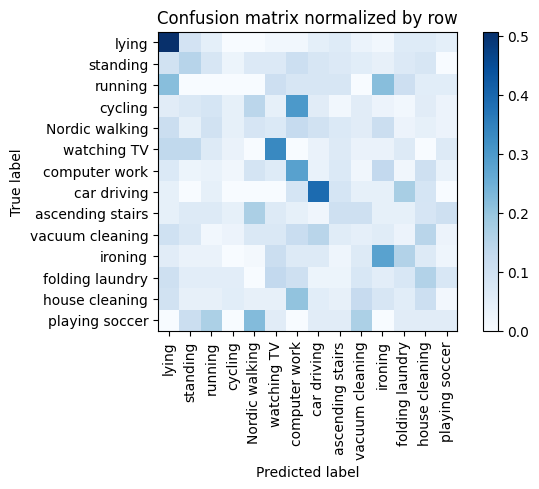

Training Epoch:  30%|███       | 3/10 [00:11<00:25,  3.68s/it]

Overall accuracy: 0.183



eval: 100%|██████████| 26/26 [00:00<00:00, 72.42batch/s, loss=1.32]


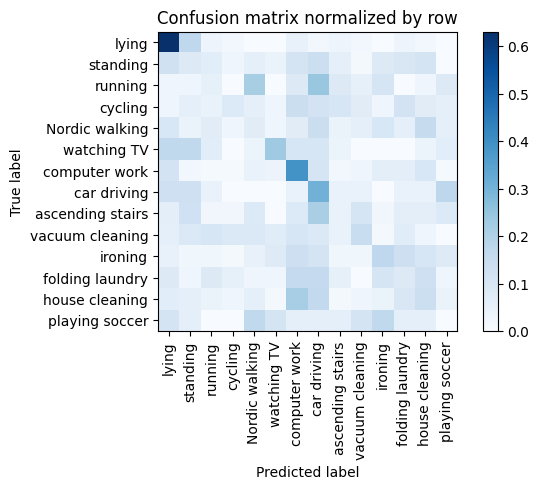

Training Epoch:  40%|████      | 4/10 [00:14<00:22,  3.68s/it]

Overall accuracy: 0.194



eval: 100%|██████████| 26/26 [00:00<00:00, 79.27batch/s, loss=1.01]


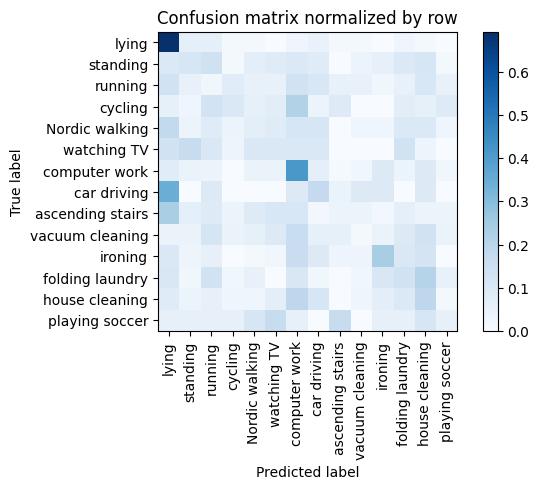

Training Epoch:  50%|█████     | 5/10 [00:17<00:17,  3.53s/it]

Overall accuracy: 0.201



eval: 100%|██████████| 26/26 [00:00<00:00, 69.70batch/s, loss=0.949]


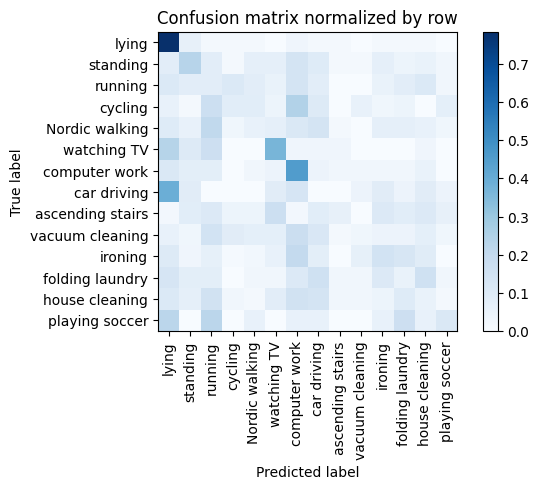

Training Epoch:  60%|██████    | 6/10 [00:22<00:14,  3.69s/it]

Overall accuracy: 0.207



eval: 100%|██████████| 26/26 [00:00<00:00, 62.80batch/s, loss=0.752]


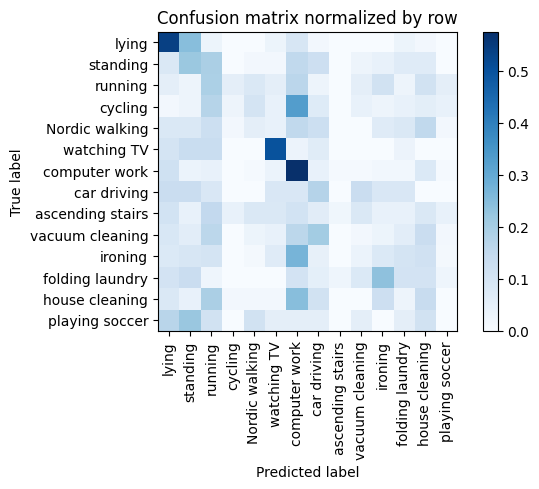

Training Epoch:  70%|███████   | 7/10 [00:26<00:11,  3.87s/it]

Overall accuracy: 0.210



eval: 100%|██████████| 26/26 [00:00<00:00, 77.38batch/s, loss=0.762]


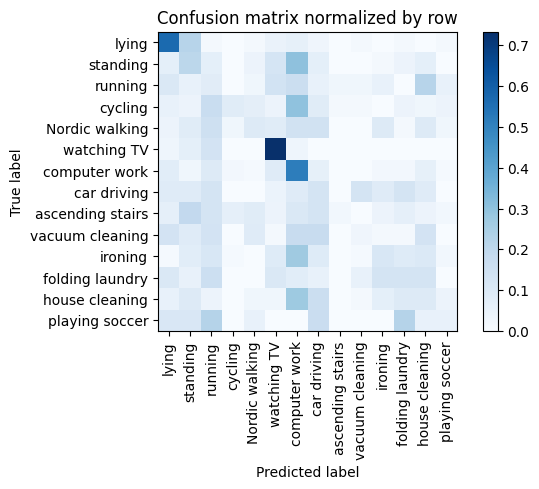

Training Epoch:  80%|████████  | 8/10 [00:29<00:07,  3.75s/it]

Overall accuracy: 0.217



eval: 100%|██████████| 26/26 [00:00<00:00, 73.76batch/s, loss=0.733]


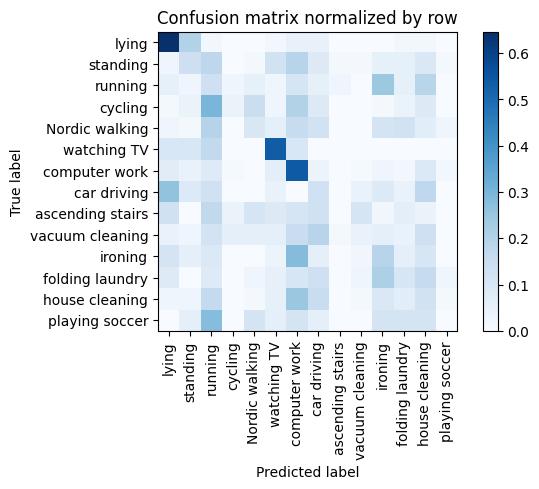

Training Epoch:  90%|█████████ | 9/10 [00:33<00:03,  3.61s/it]

Overall accuracy: 0.221



eval: 100%|██████████| 26/26 [00:00<00:00, 76.70batch/s, loss=0.693]


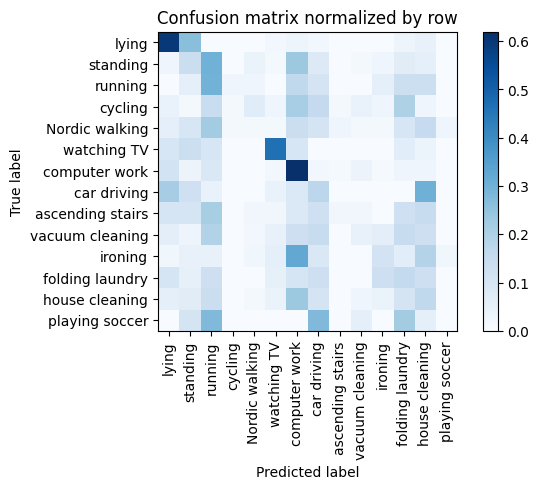

Overall accuracy: 0.223



eval: 100%|██████████| 28/28 [00:00<00:00, 96.55batch/s, loss=0.639]


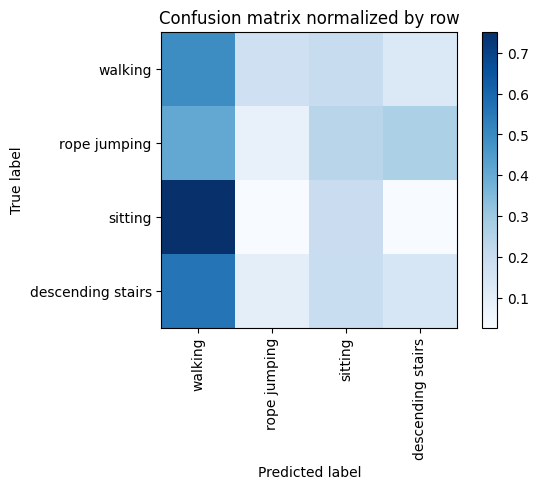

Overall accuracy: 0.302

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.358      0.493      0.415      0.423        369|	 sitting: 0.201,	rope jumping: 0.179,	
          sitting       0.314      0.193      0.239      0.326        285|	 walking: 0.751,	descending stairs: 0.028,	
descending stairs       0.221      0.142      0.173      0.170        148|	 walking: 0.561,	sitting: 0.196,	
     rope jumping       0.063      0.085      0.072      0.081         71|	 walking: 0.408,	descending stairs: 0.268,	sitting: 0.239,	

----------------------------------------------------------------------------------------------------
      avg / total       0.297      0.302      0.289        1.0        873|	      

{'total_accuracy': 0.3024054982817869, 'precision': 0.2391909892842342, 'recall': 0.2281515806337716, 'f1': 0.22482760221760942}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacu

eval: 100%|██████████| 24/24 [00:00<00:00, 76.92batch/s, loss=2.49]


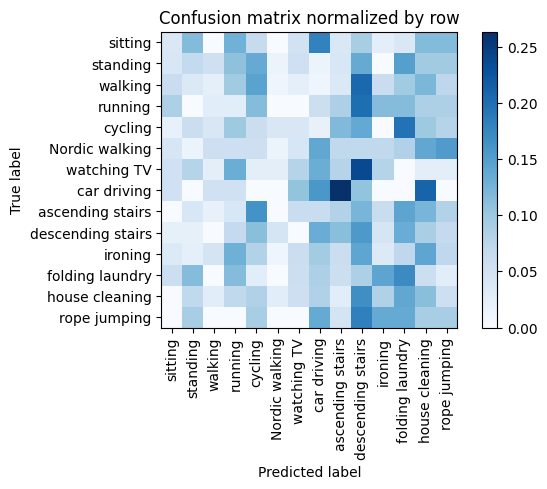

Training Epoch:  10%|█         | 1/10 [00:03<00:29,  3.32s/it]

Overall accuracy: 0.067



eval: 100%|██████████| 24/24 [00:00<00:00, 65.75batch/s, loss=1.75]


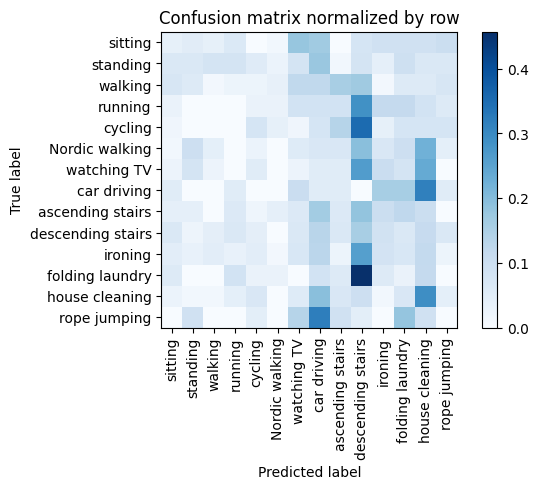

Training Epoch:  20%|██        | 2/10 [00:06<00:26,  3.29s/it]

Overall accuracy: 0.071



eval: 100%|██████████| 24/24 [00:00<00:00, 54.55batch/s, loss=1.05]


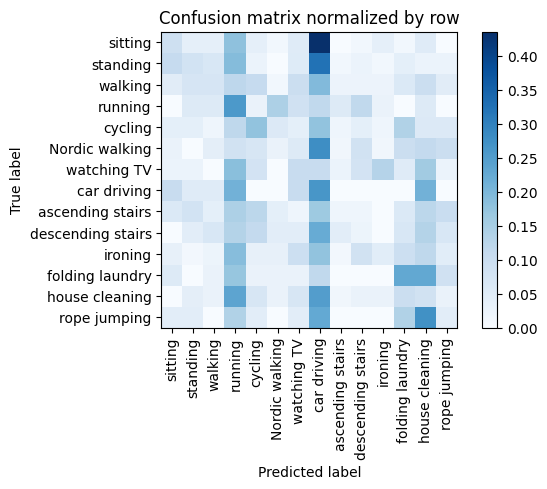

Training Epoch:  30%|███       | 3/10 [00:09<00:23,  3.34s/it]

Overall accuracy: 0.091



eval: 100%|██████████| 24/24 [00:00<00:00, 71.22batch/s, loss=0.821]


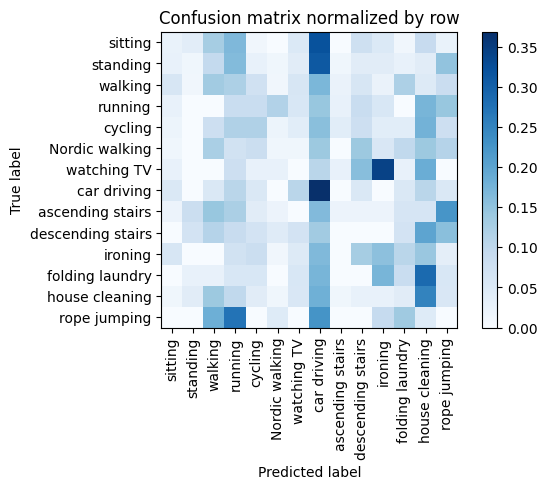

Training Epoch:  40%|████      | 4/10 [00:13<00:20,  3.43s/it]

Overall accuracy: 0.087



eval: 100%|██████████| 24/24 [00:00<00:00, 83.33batch/s, loss=0.819]


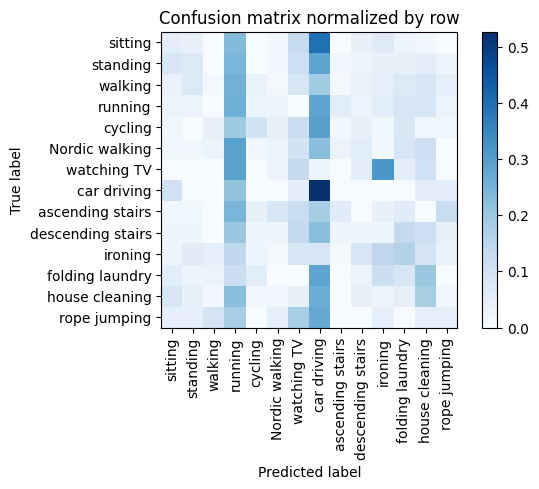

Training Epoch:  50%|█████     | 5/10 [00:16<00:17,  3.41s/it]

Overall accuracy: 0.098



eval: 100%|██████████| 24/24 [00:00<00:00, 79.21batch/s, loss=0.627]


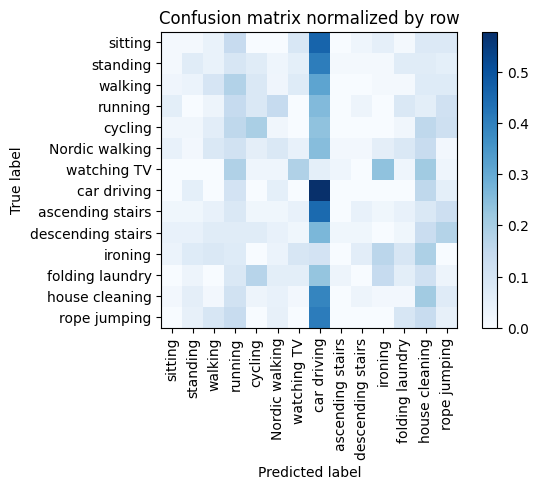

Training Epoch:  60%|██████    | 6/10 [00:20<00:13,  3.45s/it]

Overall accuracy: 0.113



eval: 100%|██████████| 24/24 [00:00<00:00, 75.71batch/s, loss=0.726]


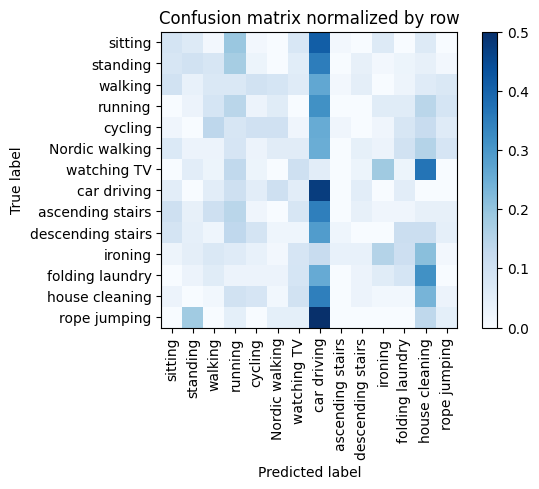

Training Epoch:  70%|███████   | 7/10 [00:23<00:10,  3.35s/it]

Overall accuracy: 0.107



eval: 100%|██████████| 24/24 [00:00<00:00, 77.92batch/s, loss=0.626]


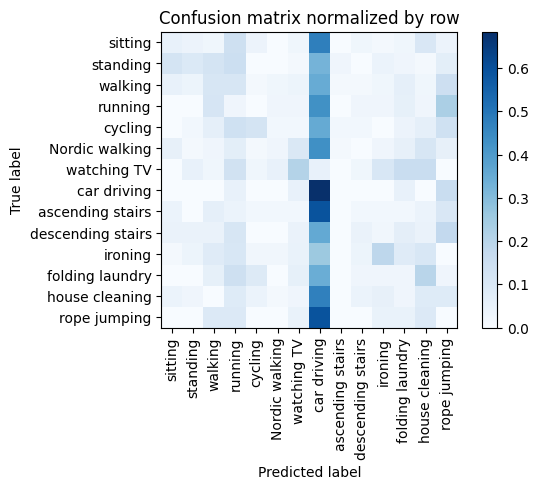

Training Epoch:  80%|████████  | 8/10 [00:26<00:06,  3.29s/it]

Overall accuracy: 0.099



eval: 100%|██████████| 24/24 [00:00<00:00, 72.51batch/s, loss=0.607]


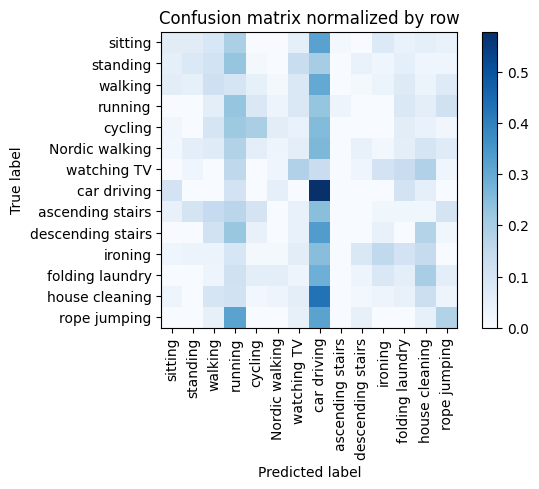

Training Epoch:  90%|█████████ | 9/10 [00:30<00:03,  3.53s/it]

Overall accuracy: 0.115



eval: 100%|██████████| 24/24 [00:00<00:00, 75.47batch/s, loss=0.646]


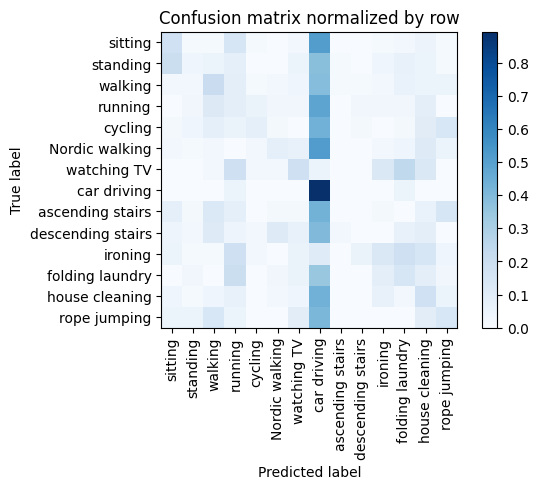

Overall accuracy: 0.136



eval: 100%|██████████| 35/35 [00:00<00:00, 83.93batch/s, loss=0.707]


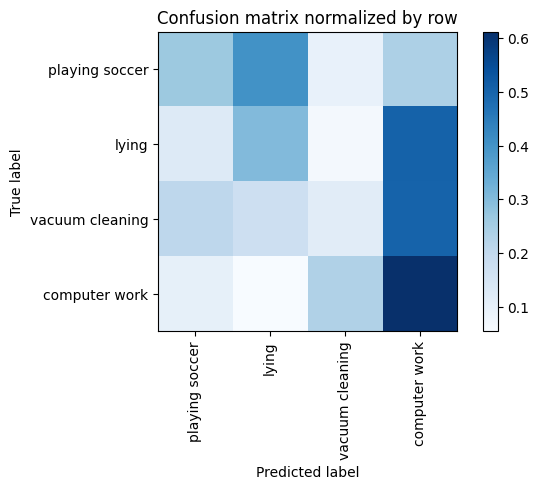

Overall accuracy: 0.389

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.496      0.612      0.548      0.432        477|	 vacuum cleaning: 0.233,	playing soccer: 0.101,	
          lying       0.466      0.302      0.367      0.263        291|	 computer work: 0.505,	playing soccer: 0.127,	
vacuum cleaning       0.185      0.117      0.143      0.240        265|	 computer work: 0.502,	playing soccer: 0.208,	lying: 0.174,	
 playing soccer       0.119      0.264      0.165      0.065         72|	 lying: 0.403,	computer work: 0.236,	

----------------------------------------------------------------------------------------------------
    avg / total       0.389      0.389      0.378        1.0       1105|	      

{'total_accuracy': 0.3891402714932127, 'precision': 0.31634616207625305, 'recall': 0.3238587120966522, 'f1': 0.30554957491109125}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'No

eval: 100%|██████████| 27/27 [00:00<00:00, 65.85batch/s, loss=5.85]


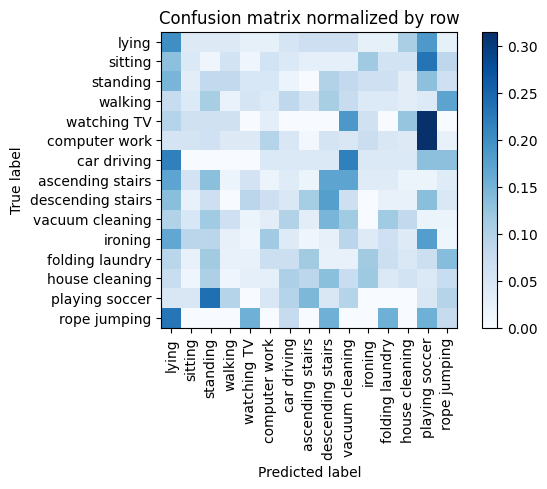

Training Epoch:  10%|█         | 1/10 [00:04<00:37,  4.18s/it]

Overall accuracy: 0.076



eval: 100%|██████████| 27/27 [00:00<00:00, 66.50batch/s, loss=2.06]


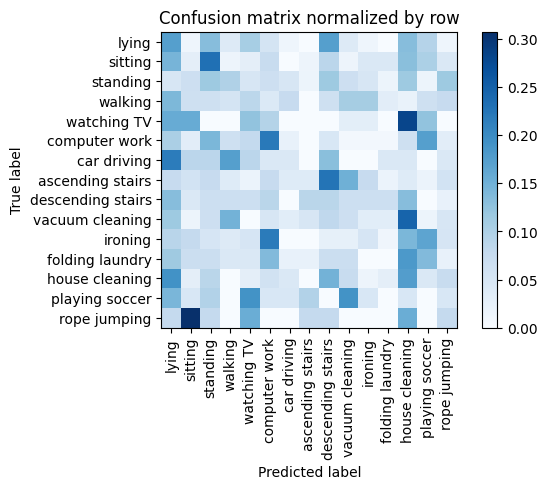

Training Epoch:  20%|██        | 2/10 [00:08<00:33,  4.17s/it]

Overall accuracy: 0.101



eval: 100%|██████████| 27/27 [00:00<00:00, 76.49batch/s, loss=1.21]


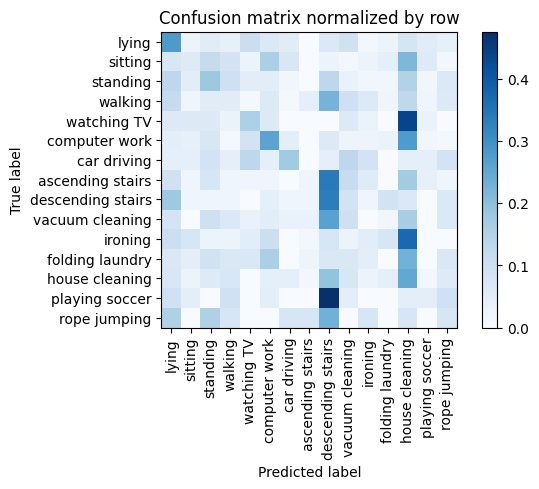

Training Epoch:  30%|███       | 3/10 [00:12<00:28,  4.12s/it]

Overall accuracy: 0.148



eval: 100%|██████████| 27/27 [00:00<00:00, 69.77batch/s, loss=1.31]


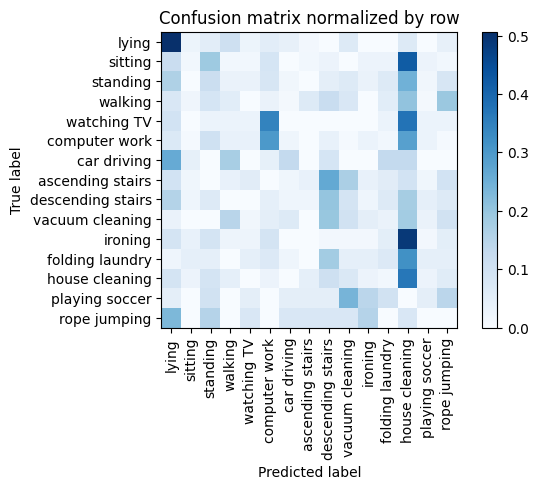

Training Epoch:  40%|████      | 4/10 [00:16<00:23,  3.93s/it]

Overall accuracy: 0.162



eval: 100%|██████████| 27/27 [00:00<00:00, 78.26batch/s, loss=0.855]


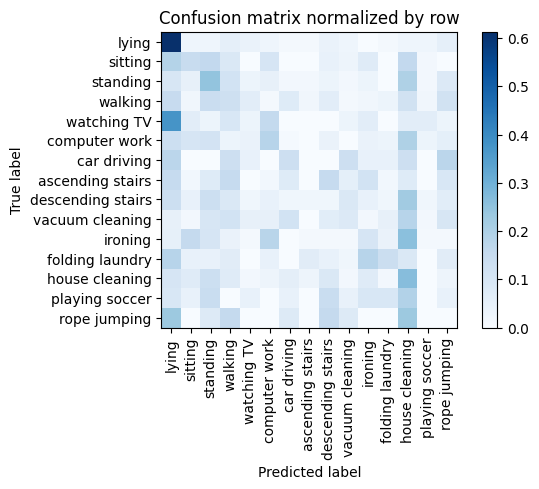

Training Epoch:  50%|█████     | 5/10 [00:20<00:20,  4.02s/it]

Overall accuracy: 0.171



eval: 100%|██████████| 27/27 [00:00<00:00, 71.43batch/s, loss=1]


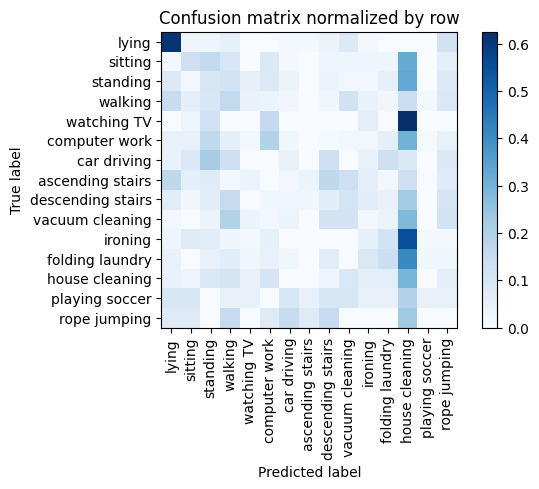

Training Epoch:  60%|██████    | 6/10 [00:24<00:16,  4.01s/it]

Overall accuracy: 0.168



eval: 100%|██████████| 27/27 [00:00<00:00, 70.60batch/s, loss=0.594]


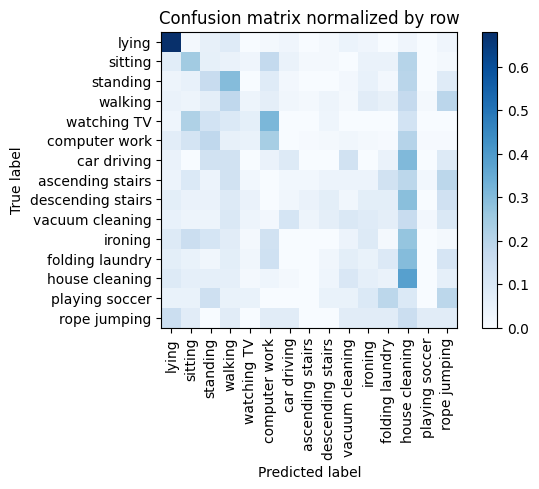

Training Epoch:  70%|███████   | 7/10 [00:28<00:12,  4.03s/it]

Overall accuracy: 0.205



eval: 100%|██████████| 27/27 [00:00<00:00, 69.05batch/s, loss=0.575]


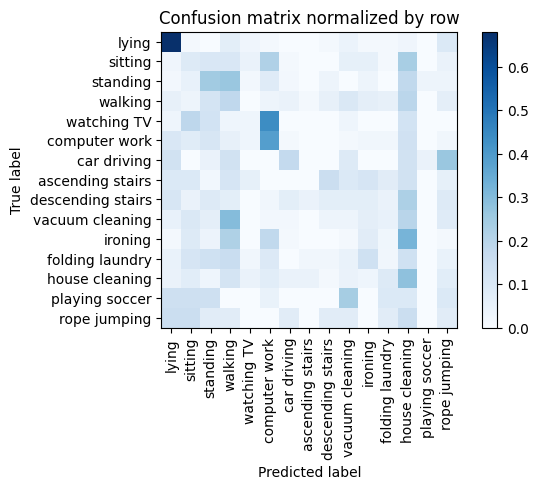

Training Epoch:  80%|████████  | 8/10 [00:32<00:08,  4.06s/it]

Overall accuracy: 0.203



eval: 100%|██████████| 27/27 [00:00<00:00, 70.31batch/s, loss=0.556]


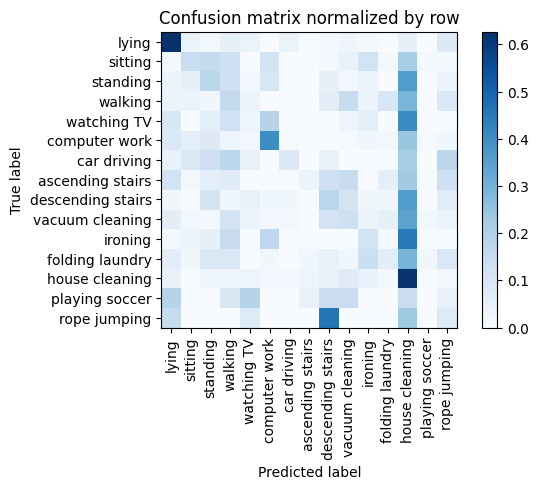

Training Epoch:  90%|█████████ | 9/10 [00:36<00:04,  4.08s/it]

Overall accuracy: 0.243



eval: 100%|██████████| 27/27 [00:00<00:00, 72.39batch/s, loss=0.603]


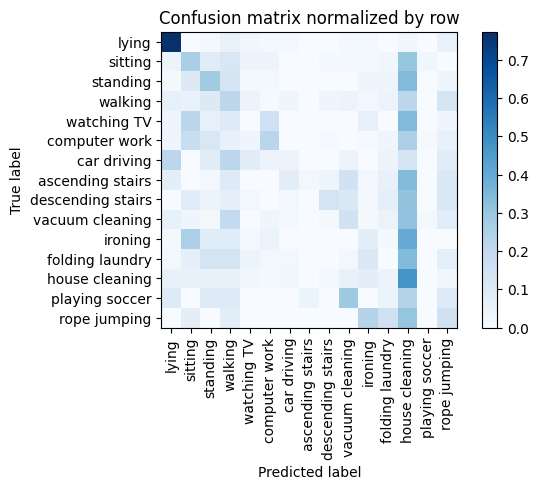

Overall accuracy: 0.229



eval: 100%|██████████| 22/22 [00:00<00:00, 80.58batch/s, loss=1.27] 


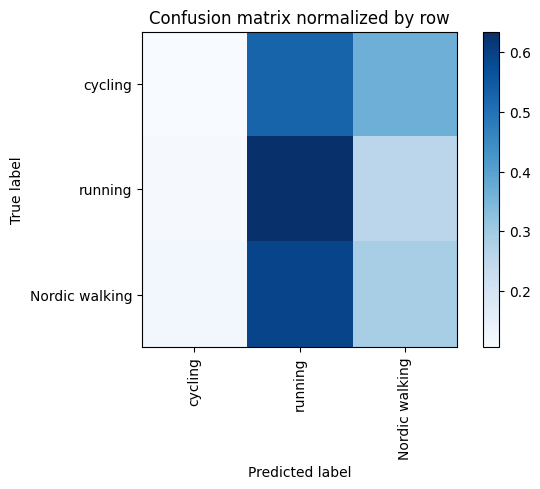

Overall accuracy: 0.293

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.385      0.289      0.330      0.415        284|	 running: 0.592,	cycling: 0.120,	
       cycling       0.351      0.105      0.162      0.374        256|	 running: 0.527,	Nordic walking: 0.367,	
       running       0.233      0.634      0.341      0.212        145|	 Nordic walking: 0.255,	cycling: 0.110,	

----------------------------------------------------------------------------------------------------
   avg / total       0.340      0.293      0.270        1.0        685|	      

{'total_accuracy': 0.2934306569343066, 'precision': 0.3228457562920034, 'recall': 0.3428946343289623, 'f1': 0.2776275940595189}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


eval: 100%|██████████| 28/28 [00:00<00:00, 69.83batch/s, loss=4.93]


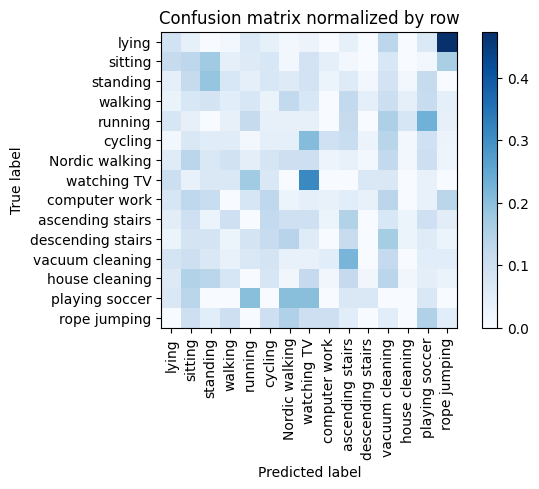

Training Epoch:  10%|█         | 1/10 [00:03<00:34,  3.86s/it]

Overall accuracy: 0.088



eval: 100%|██████████| 28/28 [00:00<00:00, 65.88batch/s, loss=1.82]


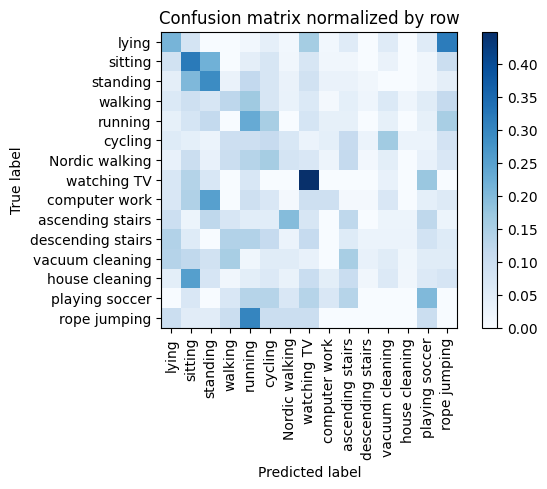

Training Epoch:  20%|██        | 2/10 [00:07<00:30,  3.83s/it]

Overall accuracy: 0.145



eval: 100%|██████████| 28/28 [00:00<00:00, 65.27batch/s, loss=1.29]


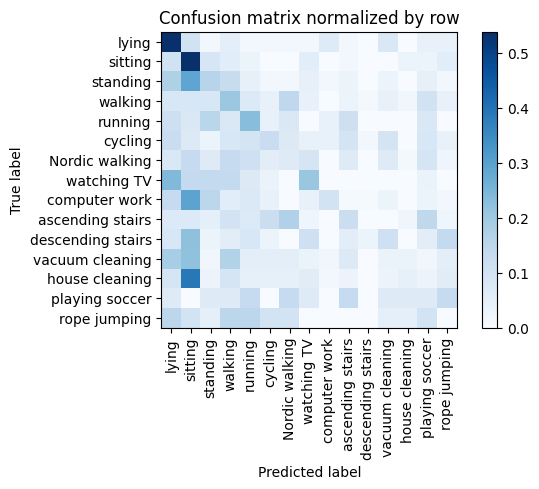

Training Epoch:  30%|███       | 3/10 [00:11<00:27,  3.96s/it]

Overall accuracy: 0.181



eval: 100%|██████████| 28/28 [00:00<00:00, 63.19batch/s, loss=0.731]


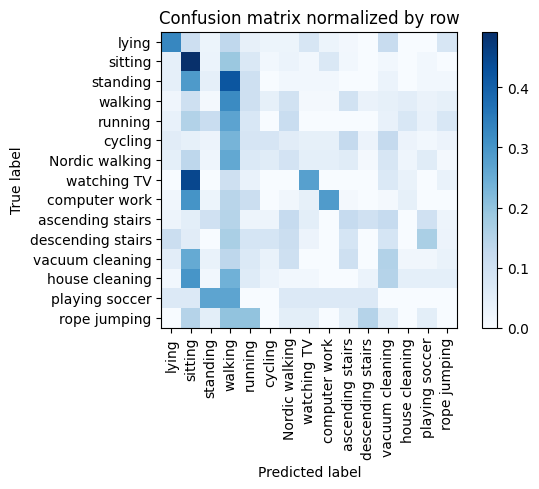

Training Epoch:  40%|████      | 4/10 [00:16<00:26,  4.37s/it]

Overall accuracy: 0.190



eval: 100%|██████████| 28/28 [00:00<00:00, 40.23batch/s, loss=0.668]


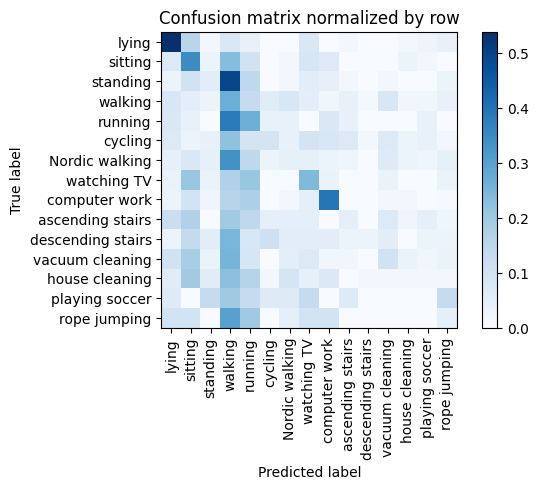

Training Epoch:  50%|█████     | 5/10 [00:22<00:25,  5.03s/it]

Overall accuracy: 0.201



eval: 100%|██████████| 28/28 [00:00<00:00, 48.11batch/s, loss=0.624]


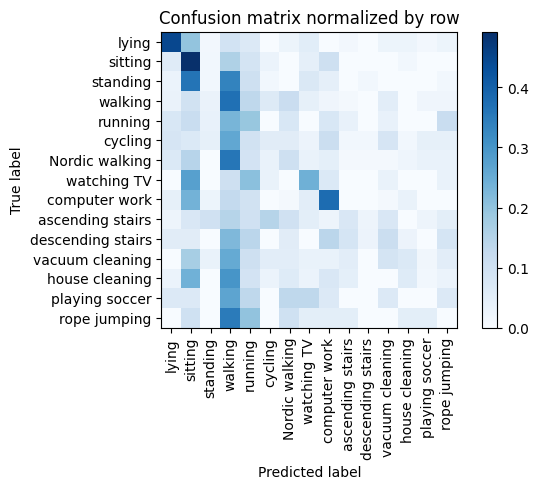

Training Epoch:  60%|██████    | 6/10 [00:28<00:20,  5.21s/it]

Overall accuracy: 0.212



eval: 100%|██████████| 28/28 [00:00<00:00, 64.37batch/s, loss=0.634]


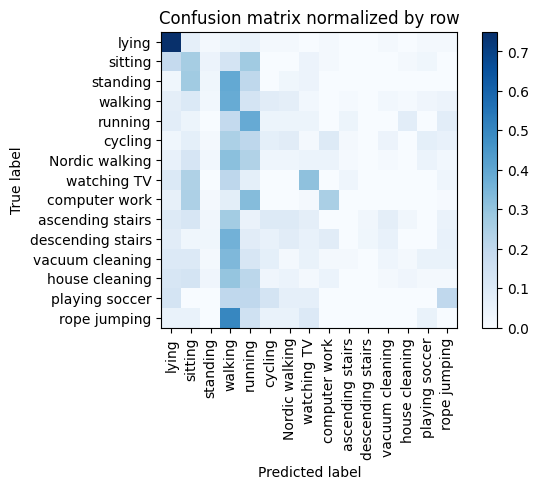

Training Epoch:  70%|███████   | 7/10 [00:33<00:15,  5.15s/it]

Overall accuracy: 0.199



eval: 100%|██████████| 28/28 [00:00<00:00, 45.53batch/s, loss=0.861]


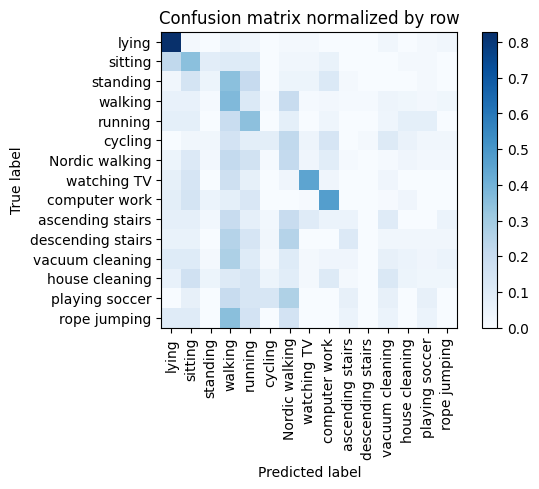

Training Epoch:  80%|████████  | 8/10 [00:38<00:10,  5.24s/it]

Overall accuracy: 0.270



eval: 100%|██████████| 28/28 [00:00<00:00, 57.49batch/s, loss=0.519]


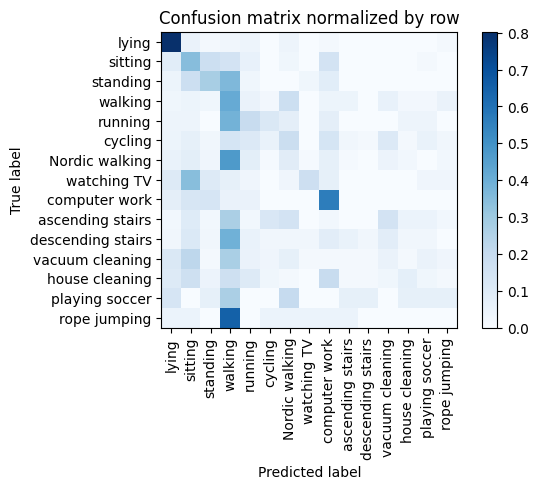

Training Epoch:  90%|█████████ | 9/10 [00:44<00:05,  5.38s/it]

Overall accuracy: 0.275



eval: 100%|██████████| 28/28 [00:00<00:00, 69.48batch/s, loss=0.6]


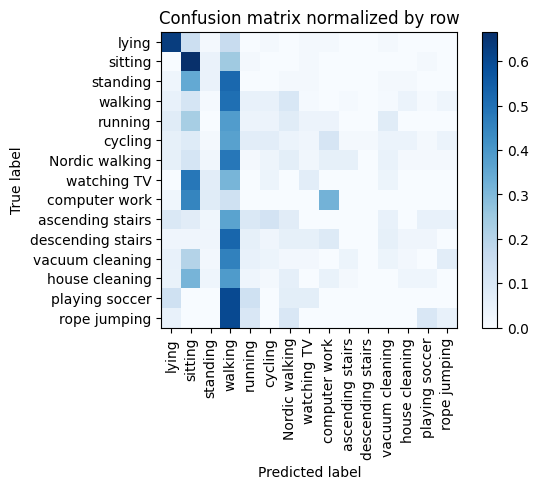

Overall accuracy: 0.229



eval: 100%|██████████| 19/19 [00:00<00:00, 69.09batch/s, loss=0.532]


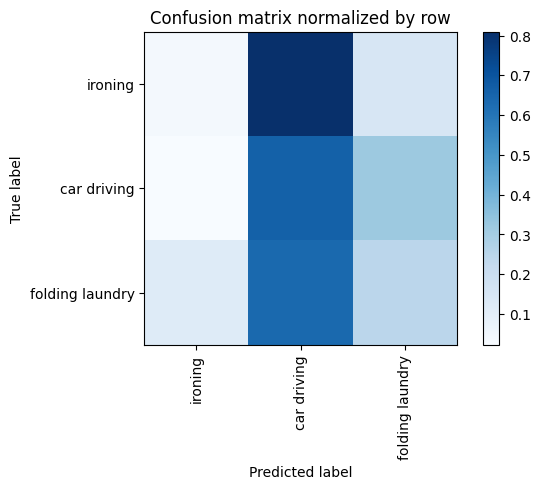

Overall accuracy: 0.185

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.400      0.040      0.072      0.588        352|	 car driving: 0.810,	folding laundry: 0.151,	
folding laundry       0.325      0.245      0.280      0.265        159|	 car driving: 0.635,	ironing: 0.119,	
    car driving       0.131      0.659      0.218      0.147         88|	 folding laundry: 0.318,	ironing: 0.023,	

----------------------------------------------------------------------------------------------------
    avg / total       0.341      0.185      0.149        1.0        599|	      

{'total_accuracy': 0.18530884808013356, 'precision': 0.28521021021021026, 'recall': 0.3147155517438536, 'f1': 0.1899888088145679}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.272870
precision         0.281648
recall            0.279431
f1                0.233024
dtype: float64

In [9]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=1, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model7(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], dim_feedforward=config['dim_feedforward'], 
                num_layers=config['num_layers'], ft_size=feat_size, attr_size=attr_size, max_len=seq_len, pos_encoding=config['pos_encoding'], activation=config['activation'], norm=config['norm'])
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=True)
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=True, print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval', with_attrs=True)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    